# Big Data Methods


In [94]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import KFold, RepeatedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, get_scorer_names
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from scipy.stats.mstats import winsorize

In [95]:
# import scikeras
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore', message='Setting the random state for TF')

from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from tensorflow.keras import regularizers
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [96]:
# Import matplotlib for graphs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

# Set global parameters
%matplotlib inline
plt.style.use('seaborn-white')
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14

## Import and prepare data

In [97]:
# load data
train = pd.read_csv('training.csv', index_col='id')
test = pd.read_csv('X_test.csv', index_col='id')

test_Y = pd.read_csv('y_test_example.csv', index_col='id')
# for the submission, overwrite all y value with na
# will populate with our prediction later
test_Y['rent_full'] = np.nan

train.head()

,GDENAMK,GDENR,KTKZ,address,area,balcony,basement,bath,cabletv,cheminee,...,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_lake,dist_to_main_stat,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
id,,,,,,,,,,,,,,,,,,,,,
1,Chavornay,5749,VD,"Rue de Sadaz 15, 1373 Chavornay",80.0,NaN,NaN,NaN,NaN,NaN,...,12760.941970,542.609436,845.529420,NaN,542.609436,39.051248,542.609436,0,0,1232.655713
2,Grenchen,2546,SO,"Viaduktstrasse 8, 2540 Grenchen",90.0,1.0,NaN,NaN,1.0,NaN,...,8755.851529,78.517514,2880.772987,NaN,850.367568,413.146463,535.210239,7,0,1124.472721
3,Vevey,5890,VD,1800 Vevey,32.0,NaN,NaN,NaN,NaN,NaN,...,6926.931211,21.931712,2209.414402,166.042100,302.702825,140.035710,302.702825,45,5,6661.799045
4,Bern,351,BE,"Spitalackerstrasse 16, 3013 Bern BE",77.0,1.0,NaN,NaN,1.0,NaN,...,869.835042,69.462220,1390.906539,3528.066226,1537.693077,332.987988,1537.693077,11,3,438.552999
5,Winterthur,230,ZH,"Im Geissacker 40, 8404 Winterthur",NaN,1.0,NaN,NaN,1.0,NaN,...,575.800313,92.849340,2169.393694,2178.792308,2983.516382,136.619911,352.512411,2,2,897.649851


In [98]:
# train.drop_duplicates() 
# no duplicates found. good!

In [99]:
# summary statistics
train.describe()

,GDENR,area,balcony,basement,bath,cabletv,cheminee,dishwasher,dryer,elevator,...,dist_to_5G,dist_to_haltst,dist_to_highway,dist_to_lake,dist_to_main_stat,dist_to_school_1,dist_to_train_stat,restaur_pix_count_km2,superm_pix_count_km2,dist_to_river
count,72000.000000,57767.000000,34520.0,976.0,496.0,24906.0,3330.0,1178.0,572.0,21939.0,...,72000.000000,71492.000000,72000.000000,38262.000000,50571.000000,71498.000000,72000.000000,72000.000000,72000.000000,72000.000000
mean,2879.512722,82.959233,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,7638.035391,166.852546,2922.607580,1864.570974,1236.536863,396.477677,1057.297004,11.650417,1.721319,823.578550
std,2199.443778,34.487208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12363.592303,174.026725,3228.381560,5873.068385,1155.591313,355.310688,1158.211097,22.482845,2.219454,968.968316
min,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2.236068,2.828427,11.401754,4.638762,3.605551,1.414214,3.162278,0.000000,0.000000,0.041264
25%,404.000000,60.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1323.998583,78.873316,1145.318296,576.187827,474.067506,204.732142,374.001003,1.000000,0.000000,224.010704
50%,2766.000000,80.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,3529.439957,130.387883,1984.648834,1204.365110,885.849874,327.678196,684.942698,3.000000,1.000000,515.221416
75%,4776.000000,101.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,9033.896515,202.141040,3410.488088,2176.086622,1613.165521,473.608488,1243.497085,9.000000,3.000000,1065.183279
max,6810.000000,945.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,88563.904680,4967.810886,41454.525950,205028.994100,15405.006360,7534.579285,23787.109950,136.000000,12.000000,8233.113960


In [100]:
# how many non-missing values per feature
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72000 entries, 1 to 72000
Data columns (total 82 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   GDENAMK                         72000 non-null  object 
 1   GDENR                           72000 non-null  int64  
 2   KTKZ                            72000 non-null  object 
 3   address                         72000 non-null  object 
 4   area                            57767 non-null  float64
 5   balcony                         34520 non-null  float64
 6   basement                        976 non-null    float64
 7   bath                            496 non-null    float64
 8   cabletv                         24906 non-null  float64
 9   cheminee                        3330 non-null   float64
 10  date                            72000 non-null  object 
 11  descr                           51473 non-null  object 
 12  dishwasher                      

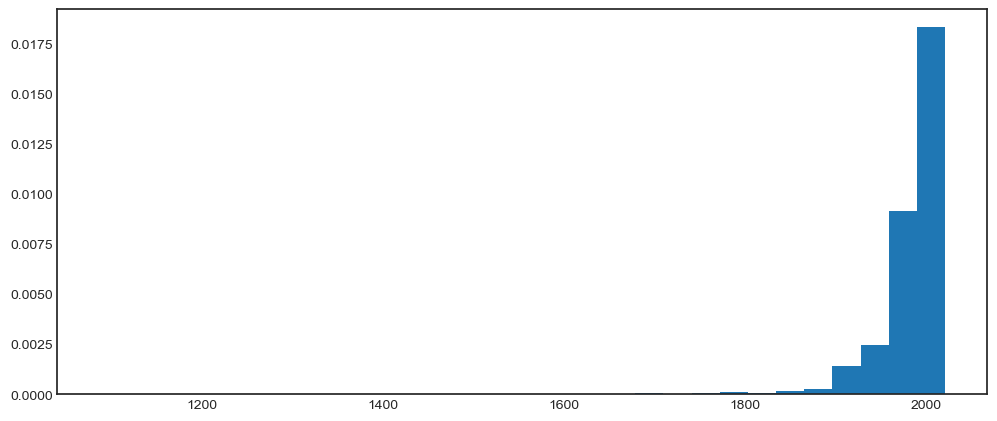

In [101]:
# plt.hist(np.log2(train['year_built']), bins=30, density=True)
plt.hist(train['year_built'], bins=30, density=True)
plt.show()

<AxesSubplot:xlabel='rooms', ylabel='area'>

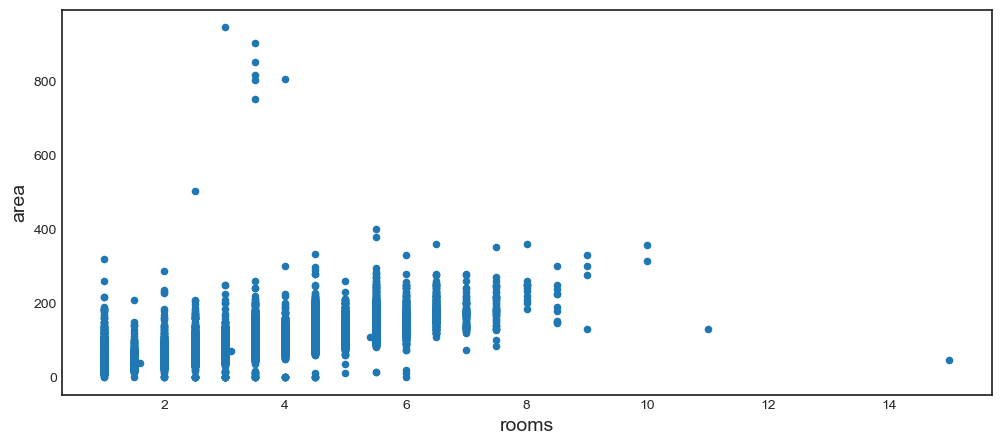

In [102]:
train.plot.scatter(x='rooms', y='area')

In [103]:
def prepare_clean_data(data):
    df = data.drop(['GDENAMK', 'year', 'date', 'lat', 'lon', ], axis=1)
    # GDENAMK, we have id: GDENR, we use msregion as best location indicator.
    # quarter_specific not needed, we have year and quarter (and date) already
    # 'year' listed is always 2019, redundant

    # drop least useful location indicator
    df = df.drop(['GDENR', 'KTKZ', 'address'], axis=1)

    # drop dummy columns with many missing values
    # dropped due to low data quality => low predictive power
    # floors has negative values and quite a few missing.
    df = df.drop(['basement', 'bath', 'cheminee', 'dishwasher', 'dryer', 
                'furnished', 'gardenshed', 'heating_air', 'heating_earth', 
                'heating_electro', 'heating_far', 'heating_gas', 'heating_oil', 
                'heating_pellets', 'kids_friendly', 'laundry', 'manlift', 'middle_house', 
                'oven', 'playground', 'pool', 'quiet', 'raised_groundfloor', 'shower',
                'sunny', 'terrace', 'toilets', 'topstorage', 'veranda', 'water', 'oldbuilding', ], axis=1)

    # the following have over 10'000 positive answers. We keep for the prediction.
    for c in ['balcony', 'cabletv', 'elevator', 'parking_indoor', 'parking_outside', ]:
        df[c] = np.where(np.isnan(df[c]), 0, 1)

    # impute area based on msregion, home_type, and number of rooms => median b.c. outliers in area
    df['area'] = df['area'].fillna(df.groupby(['home_type', 'rooms',])['area'].transform('median'))

    # # replace description text with dummy, if description exists or not
    df = df.astype({'descr': str})
    df['descr'] = np.where(df.descr=='nan', 0, df.descr.str.len())

    # has any parking
    df['parking_any'] = np.where((df.parking_indoor==1) & (df.parking_outside==1), 0, 1)

    # impute floors with average
    df['floors'] = df['floors'].fillna(df['avg_anzhl_geschosse'])

    # impute year_built
    df['year_built'] = np.where(df['year_built']==-1 , np.nan, df['year_built'])
    df['year_built'] = df['year_built'].fillna(df['avg_bauperiode'])
    df['year_built'] = df['year_built']**20 # fix left skew

    # log transform right skewed distributions
    for f in ['Noise_max', 'dist_to_4G', 'dist_to_5G']:
        df[f] = df[f]+1

    for f in ['wgh_avg_sonnenklasse_per_egid', 'Avg_age', 'Avg_size_household',
            'Noise_max', 'avg_anzhl_geschosse', 'dist_to_4G', 
            'dist_to_5G','dist_to_haltst', 'dist_to_river' ]:
        df[f] = np.log(df[f])

    # winsorize some variables with outliers
    for f in ['Micro_rating', 'Micro_rating_NoiseAndEmission', 'Micro_rating_Accessibility',
              'Micro_rating_DistrictAndArea', 'Micro_rating_SunAndView', 'Micro_rating_ServicesAndNature',
              'wgh_avg_sonnenklasse_per_egid', 'Anteil_auslaend', 'Avg_age', 'Avg_size_household',
              'Avg_size_household', 'Noise_max', 'avg_anzhl_geschosse', 'avg_bauperiode',
              'dist_to_4G', 'dist_to_5G', 'dist_to_haltst', 'dist_to_highway', 'dist_to_school_1',
              'dist_to_train_stat', 'dist_to_river', 'year_built']:
        df[f] = winsorize(df[f], limits=[0.03, 0.03], nan_policy='propagate')   

    # the following variables are categorical or the numerical representation is not meaningful 
    # (e.g. larger numbers not systematically different from smaller numbers)
    # transform into dummies
    for f in ['msregion', 'home_type', 'rooms']:
        dummies = pd.get_dummies(df[f], prefix=str(f), drop_first=False) 
        df = df.merge(dummies, left_index=True, right_index=True)
        df = df.drop(f, axis=1) # drop the original variable

    # other vars we don't want, mostly because too little data or no meaningful improvement by including
    df = df.drop(['dist_to_lake', 'dist_to_main_stat', 'quarter_specific', 
                'quarter_general', 'month', 'anteil_efh', 'avg_anzhl_geschosse', 
                'avg_bauperiode', ], axis=1)

    return df

In [104]:
# clean data
df_train = prepare_clean_data(train)
df_test = prepare_clean_data(test)

# ensure test data has all the right columns
# Get missing columns in the training test
missing_cols = set( df_train.columns ) - set( df_test.columns )

# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_test[c] = 0 # constant

# Ensure the order of column in the test set is in the same order than in train set
df_test = df_test[df_train.columns]
df_test = df_test.drop('rent_full', axis=1)


In [105]:
# standardize train and test data (except the dummies)
cols_to_scale = ['area',
                 'Micro_rating', 'Micro_rating_NoiseAndEmission', 'Micro_rating_Accessibility',
                 'wgh_avg_sonnenklasse_per_egid', 'Anteil_auslaend', 'Avg_age', 'Avg_size_household',
                 'Avg_size_household', 'Noise_max', 'descr', 'dist_to_4G', 'dist_to_5G',
                 'dist_to_haltst', 'dist_to_highway', 'dist_to_school_1',
                 'dist_to_train_stat', 'dist_to_river', 'year_built' ]

scaler = StandardScaler()
scaler.fit(df_train[cols_to_scale])
df_train[cols_to_scale] = scaler.transform(df_train[cols_to_scale])

# scale test data with the fit from train data
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [106]:
# handle rows with missing data
    
# training    
df_train = df_train.dropna()
# df_test = df_test.dropna()

# testing
temp = df_test.copy()
df_test = temp.dropna() # we only predict on the rows that are possible

# we safe the index of the test data for which we have missing data
df_test_missing = temp.merge(df_test, left_index=True, right_index=True, how='left', indicator=True)
df_test_missing = df_test_missing[df_test_missing['_merge'] == 'left_only']
df_test_missing = df_test_missing[[]] # only keep the index column

## Training

In [107]:
# train values for X and y
X = df_train.drop(['rent_full'], axis=1).values
y = df_train.rent_full.values

In [108]:
# set aside validation data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1)
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_valid:", X_valid.shape)
print("Shape of y_valid:", y_valid.shape)

Shape of X_train: (55255, 168)
Shape of y_train: (55255,)
Shape of X_valid: (13814, 168)
Shape of y_valid: (13814,)


### OLS

In [109]:
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=KFold(n_splits=10))
avg_score = np.mean(scores)
print(f'Features: {len(df_train.columns)-1}, Obs: {len(df_train):_}, MSE: {int(-1*avg_score):_}'.replace('_', "'"))

# all 'bad' dummies included and NA coded as 0, Msregion only
# =>                                                    Features: 214, Obs: 55'209, MSE: 361'972'499'893

# No 'bad' dummies                                      Features: 177, Obs: 55'209, MSE: 142'565
# some 'bad' dummies (>10'000 responses)                Features: 182, Obs: 55'209, MSE: 139'787

# msregion and KTKZ:                                    Features: 208, Obs: 55'209, MSE: 139'779
# ==> msregion only b.c. fewer features

# area imputed (type, rooms):                           Features: 182, Obs: 68'136, MSE: 141'183
# area imputed (msregion, type, rooms):                 Features: 182, Obs: 67'890, MSE: 140'556
# ==> more observations. keep
# ==> TODO, which one better? kept the one without msregion

# added dummy for description                           Features: 183, Obs: 68'136, MSE: 141'173
# added description length                              Features: 183, Obs: 68'136, MSE: 140'855
# description length helpful 

# dummy for any parking                                 Features: 184, Obs: 68'136, MSE: 140'849
# slightly better

# quarter and month of listing ignored.                 Features: 169, Obs: 68'136, MSE: 140'886
# ==> same mse with fewer features

# drop anteil_efh                                       Features: 168, Obs: 68'136, MSE: 140'881

# standardize vars:                                     Features: 168, Obs: 68'136, MSE: 140'881
# ==> no impact, as expected

# log transform for better normal distribution          Features: 168, Obs: 68'136, MSE: 140'727
# => slightly better
# log of area makes mse much worse. too much discounted

# winsorize all (expect area)
# (3%, 3%):                                             Features: 168, Obs: 69'069, MSE: 140'595
# (5%, 5%):                                             Features: 168, Obs: 71'276, MSE: 143'470
# (1%, 1%):                                             Features: 168, Obs: 69'069, MSE: 140'637
# => 3% symmetric winsorization

# impute floors from average_geschosse and drop that average
#                                                        Features: 168, Obs: 69'069, MSE: 140'549       
# ==> floors could be better than average, as more precise, use that 

# impute year_built from average and drop said average
#                                                        Features: 168, Obs: 69'069, MSE: 140'504
# with left skew corrected and standardized              Features: 168, Obs: 69'069, MSE: 139'987

Features: 168, Obs: 69'069, MSE: 139'574


In [110]:
# fit OLS model
ols = LinearRegression()
history = ols.fit(X_train, y_train)
y_hat = history.predict(X_valid)
print(f'Features: {len(df_train.columns)-1}, Obs: {len(df_train):_}, MSE: {int(mean_squared_error(y_valid, y_hat)):_}'.replace('_', "'"))

Features: 168, Obs: 69'069, MSE: 142'652


# Make prediction on final test data

In [ ]:
# USE ALL TRAIN DATA X, NOT JUST X_TRAIN!
history2 = ols.fit(X, y)

In [ ]:
def Predict(test_data, model, missing):
  yhat = model.predict(test_data)
  temp1 = pd.DataFrame({'idx': test_data.index, 'values': yhat}); temp2 = pd.DataFrame({'idx': missing.index})
  temp = pd.concat([temp1,temp2],axis=0).sort_values(by='idx')
  if temp['idx'].duplicated().any() == True: print('ATTENTION: Some indexes are duplicated.') # flagging errors
  yhat = temp['values'].to_list()
  return(yhat)

In [ ]:
submission = pd.DataFrame(Predict(df_test, history2, df_test_missing))
submission.index += 1 # so index starts at 1 not 0

In [ ]:
submission.to_csv("Prediction_XXXXX.csv", index=True, header=False)